In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [31]:
df = pd.read_csv("./processedGitHubData.csv", index_col=0)
repo_name = df.iloc[:,0]
df = df.drop(df.columns[[0,4]], axis=1, inplace=False)
print(df.head())

   forks_count  open_issues_count  watchers_count  star_count
0          107                 24             778         778
1          110                 61             776         776
2          131                  5             776         776
3          177                301             775         775
4          225                150             774         774


In [34]:
describe_table = df.describe()
describe_table

,forks_count,open_issues_count,watchers_count,star_count
count,17595.000000,17595.000000,17595.000000,17595.000000
mean,591.140040,83.676613,3007.851094,3007.851094
std,1877.682578,272.928927,6395.799670,6395.799670
min,0.000000,0.000000,35.000000,35.000000
25%,64.000000,6.000000,449.000000,449.000000
50%,206.000000,22.000000,1404.000000,1404.000000
75%,547.000000,71.000000,3150.500000,3150.500000
max,119137.000000,16750.000000,307749.000000,307749.000000


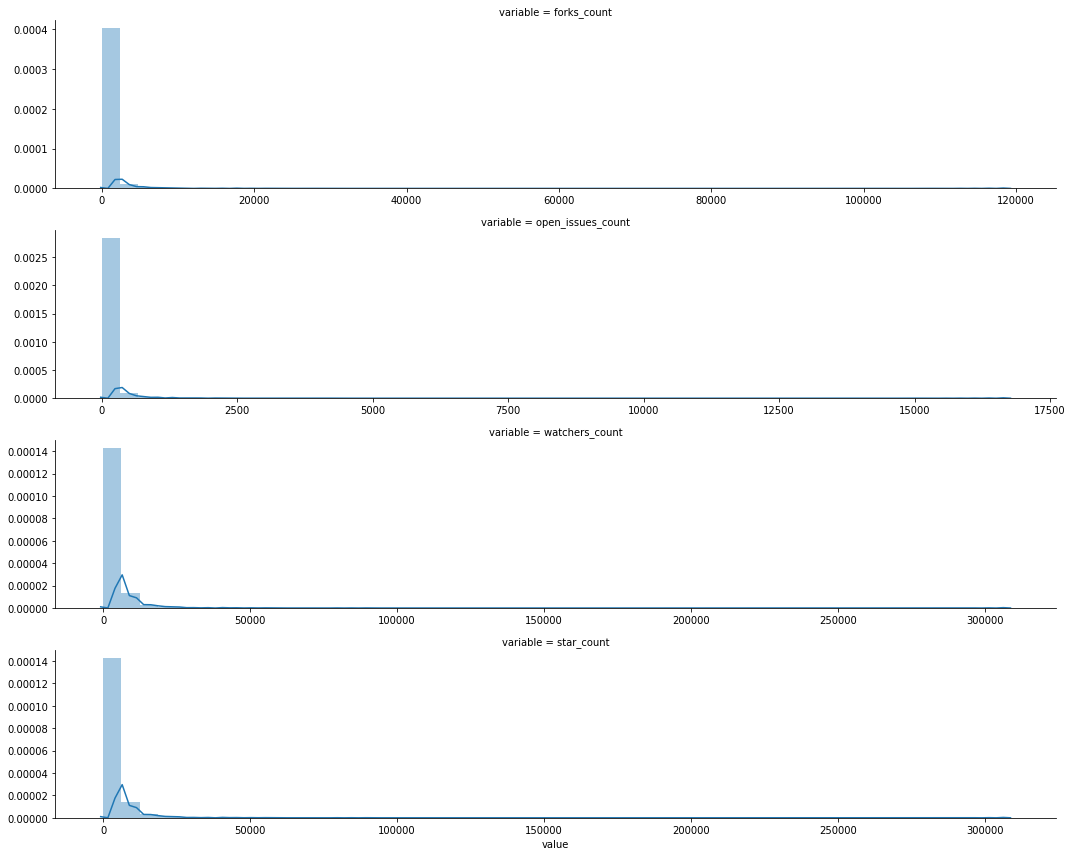

In [5]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
f = pd.melt(df, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=1, sharex=False, sharey=False, aspect = 5)
g = g.map(sns.distplot, "value")

In [36]:
describe_table.loc['cv'] = describe_table.loc['std'] / describe_table.loc['mean']
describe_table

,forks_count,open_issues_count,watchers_count,star_count
count,17595.000000,17595.000000,17595.000000,17595.000000
mean,591.140040,83.676613,3007.851094,3007.851094
std,1877.682578,272.928927,6395.799670,6395.799670
min,0.000000,0.000000,35.000000,35.000000
25%,64.000000,6.000000,449.000000,449.000000
50%,206.000000,22.000000,1404.000000,1404.000000
75%,547.000000,71.000000,3150.500000,3150.500000
max,119137.000000,16750.000000,307749.000000,307749.000000
cv,3.176375,3.261711,2.126368,2.126368


In [37]:
describe_table.loc['cv'].describe()

count    4.000000
mean     2.672706
std      0.631817
min      2.126368
25%      2.126368
50%      2.651372
75%      3.197709
max      3.261711
Name: cv, dtype: float64

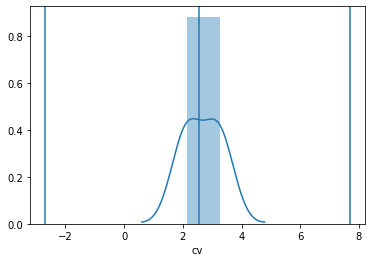

In [38]:
seaborn.distplot(describe_table.loc['cv'])
plt.axvline(2.541984)
plt.axvline(2.5 + 3*1.727345)
plt.axvline(2.5 - 3*1.727345)

In [39]:
df_normal = (df - describe_table.loc['std'])/describe_table.loc['mean']
df_normal.head()

,forks_count,open_issues_count,watchers_count,star_count
0,-2.995369,-2.974892,-1.867712,-1.867712
1,-2.990294,-2.532714,-1.868377,-1.868377
2,-2.954770,-3.201957,-1.868377,-1.868377
3,-2.876954,0.335471,-1.868709,-1.868709
4,-2.795755,-1.469095,-1.869042,-1.869042


In [12]:
repo_name_df = repo_name.to_frame()
# normalize_df = pd.concat([repo_name_df, df_normal], axis=1)
# normalize_df.to_csv("/Users/Henry/Desktop/CleanGitHubData.csv")

In [13]:
normalize_nparray = df_normal.to_numpy()

In [14]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(normalize_nparray)
kmeans.labels_
print("OK")

OK


In [15]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(kmeans.labels_)
# print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# a = onehot_ecoded.to_dataframe()
# invert first example
# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# print(inverted)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
df_normal['Label'] = onehot_encoded.tolist()
df_new = df_normal.iloc[:,:4]
df_new_np = df_new.to_numpy()

In [22]:
x_train, x_test,y_train,y_test = train_test_split(df_new_np,onehot_encoded, test_size =0.2)
x_train.shape
# sparse_categorical_crossentropy

(14076, 4)

In [29]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dropout(0.36),
  tf.keras.layers.Dense(4, activation='softmax')
])

# tf.keras.layers.Dropout(0.2)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, verbose =1)
result = model.evaluate(x_test, y_test, verbose =0)
print("Lost : " + str(result[0]))
print("Accuracy : " + str(result[1]))


Train on 14076 samples
Epoch 1/5
14076/14076 [==============================] - 2s 164us/sample - loss: 0.0874 - accuracy: 0.9857
Epoch 2/5
14076/14076 [==============================] - 2s 121us/sample - loss: 0.0242 - accuracy: 0.9934
Epoch 3/5
14076/14076 [==============================] - 2s 122us/sample - loss: 0.0118 - accuracy: 0.9955
Epoch 4/5
14076/14076 [==============================] - 2s 122us/sample - loss: 0.0149 - accuracy: 0.9955
Epoch 5/5
14076/14076 [==============================] - 2s 125us/sample - loss: 0.0097 - accuracy: 0.9963
Lost : 0.01322278222761582
Accuracy : 0.99545324


In [30]:
# Train the KNN Model
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(x_train, y_train)


# Make Prediction with the KNN Model
y_pred = classifier.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9940323955669225
